In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
import sys, os, shutil
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
colabase = Path('/content/drive/My Drive/Colab Notebooks/')
course = Path('/content/drive/My Drive/course-v3/')
dlff = Path('/content/drive/My Drive/deeplearning-ff/')
#sys.path.append(str(dlff)) # cd {dlff}
os.chdir(dlff)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive


In [0]:
#export
from exports.lg_05b import *
torch.set_num_threads(2)

## ConvNet

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3641)

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [0]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [0]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

Let's check it behaved properly.

In [0]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [0]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [0]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):
  """keeps 1st dim (batch size) and blends all other dims by multiplying them """
  return x.view(x.shape[0], -1) 

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:

In [0]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

In [0]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14 square
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7 square
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4 square
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2 square
        nn.AdaptiveAvgPool2d(1), # with args (H,W) shrinks each channel to rectangle HxW, or sqare of HxH, here 1x1 
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [0]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [0]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [0]:
opt = optim.SGD(model.parameters(), lr=0.4) # args = modelparams and leaning rate 
learn = Learner(model, opt, loss_func, data) # args = model, opt, lossfunc and data 
run = Runner(cb_funcs=cbfs) # args = callbacks, run.fit(epochs, learner)

In [0]:
%time run.fit(1, learn)

train: [1.91522828125, tensor(0.3245)]
valid: [0.577755224609375, tensor(0.8403)]
CPU times: user 6.46 s, sys: 355 ms, total: 6.82 s
Wall time: 4.29 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3799)

In [0]:
torch.cuda.is_available()
#device = torch.device("cuda") 

True

In [0]:
x_train = x_train.to("cpu");print(x_train.device)
x_train = x_train.to("cuda");print(x_train.device)

cpu
cuda:0


In [0]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [0]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [0]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [0]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [0]:
cbfs.append(CudaCallback)

In [0]:
model = get_cnn_model(data)

In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [0]:
%time run.fit(3, learn)

train: [1.811915, tensor(0.3906, device='cuda:0')]
valid: [0.451167236328125, tensor(0.8673, device='cuda:0')]
train: [0.3461900390625, tensor(0.8939, device='cuda:0')]
valid: [0.18889312744140624, tensor(0.9419, device='cuda:0')]
train: [0.17687162109375, tensor(0.9463, device='cuda:0')]
valid: [0.142813671875, tensor(0.9576, device='cuda:0')]
CPU times: user 3.09 s, sys: 962 ms, total: 4.06 s
Wall time: 4.08 s


Now, that's definitely faster!

In [0]:
#export
class CpuCallback(Callback):
    def begin_fit(self): 
      # model.to() modifies the model in place
      self.model.to("cpu") 
    def begin_batch(self):
      # tensor.to creates a copy, so you need to assign result to original tensors
      self.run.xb,self.run.yb = self.xb.to("cpu"),self.yb.to("cpu")

In [0]:
cbfs_cpu = [Recorder, partial(AvgStatsCallback,accuracy),CpuCallback]
run_cpu = Runner(cb_funcs=cbfs_cpu)

model_cpu = get_cnn_model(data)
opt_cpu = optim.SGD(model_cpu.parameters(), lr=0.4)
learn_cpu = Learner(model_cpu, opt_cpu, loss_func, data)

%time run_cpu.fit(3, learn_cpu)

train: [2.169385625, tensor(0.2150)]
valid: [1.7453669921875, tensor(0.4488)]
train: [0.6011464453125, tensor(0.8051)]
valid: [0.227076025390625, tensor(0.9314)]
train: [0.17404623046875, tensor(0.9474)]
valid: [0.1243859375, tensor(0.9639)]
CPU times: user 19.6 s, sys: 1.06 s, total: 20.7 s
Wall time: 12.9 s


## Refactor model

First we can regroup all the conv/relu in a single function:

In [0]:
x_train[1].shape;
x_train[1].view(-1,1,28,28).shape;
y=mnist_resize(x_train[1].cpu());
print(f"y.shape: {y.shape}")
print(f"flatten(y).shape: {flatten(y).shape}")
mdl = nn.Sequential(conv2d(1,8,5))#,conv2d(8,16,3),conv2d(16,32,3),conv2d(32,32,3))
#mdl = nn.Sequential(mdl, nn.AdaptiveAvgPool2d(1))
z=mdl(y)
print(f"z.shape: {z.shape}")
print(f"flatten(z).shape: {flatten(z).shape}")

y.shape: torch.Size([1, 1, 28, 28])
flatten(y).shape: torch.Size([1, 784])
z.shape: torch.Size([1, 8, 14, 14])
flatten(z).shape: torch.Size([1, 1568])


[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3961)

In [0]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())
  #padding has to be kernelsize//2 otherewise u lose info, shrink pic

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.

In [0]:
#export
class BatchTransformXCallback(Callback): # replaces Lambda(mnist)
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)#transforms x not in model but at batch time

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [0]:
mnist_view = view_tfm(1,28,28) # this function will be passed as tfm in BatchTransformXCallback BTXC
cbfs.append(partial(BatchTransformXCallback, mnist_view)) 
# u want BTXC called as function with mnist_view as arg, so u create a partial 

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [0]:
nfs = [8,16,32,32] # filters 

In [0]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [0]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [0]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [0]:
run.fit(3, learn)

train: [2.0088496875, tensor(0.2794, device='cuda:0')]
valid: [1.24050107421875, tensor(0.5886, device='cuda:0')]
train: [0.502208359375, tensor(0.8441, device='cuda:0')]
valid: [0.22856376953125, tensor(0.9352, device='cuda:0')]
train: [0.19749439453125, tensor(0.9405, device='cuda:0')]
valid: [0.13099019775390625, tensor(0.9614, device='cuda:0')]


## Hooks

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4353)

In [0]:
#export
class SequentialModel(nn.Module):
    """"manual Sequential model 2.0, with tracking, telemetry """
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers] # each layer has list 
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            # each list gets added to every time fwd pass computed, so each batch
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self):
      #when class looped on, loop on the layers
      return iter(self.layers)

In [0]:
model,learn,run = None,None,None
model =  SequentialModel(*get_cnn_layers(data, nfs)) 
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
run.fit(2, learn)

train: [2.11986625, tensor(0.2507, device='cuda:0')]
valid: [1.377434765625, tensor(0.4886, device='cuda:0')]
train: [0.65878046875, tensor(0.7846, device='cuda:0')]
valid: [0.500325927734375, tensor(0.8309, device='cuda:0')]


Now we can have a look at the means and stds of the activations at the beginning of training.

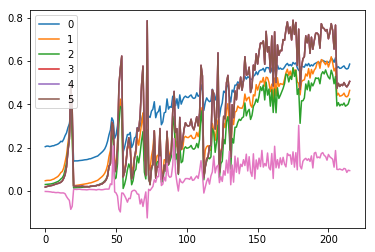

In [0]:
for l in model.act_means: plt.plot(l) #plotting each list in list-of-lists
plt.legend(range(6));
# everytime activations fall of clif, do they all recover (or do a lot stay at zero)?

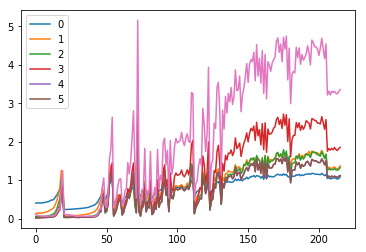

In [0]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

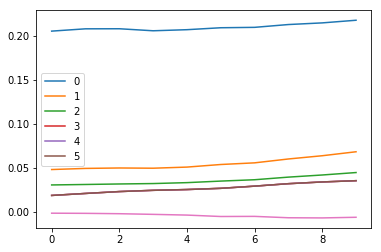

In [0]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

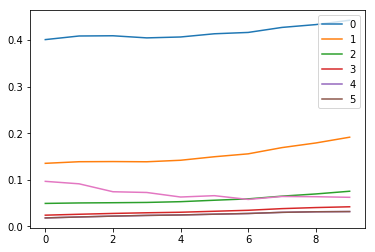

In [0]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));
# stdev of later layers exponen smaller than first ones 

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4693)

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
# global variables to store stats we need 
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [0]:
def append_stats(i, mod, inp, outp):
    # we are just interested in output so only outp gets used
    # append i-th list
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [0]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))
# register backward also exists 
# partial makes it a 3 args function that register_xxx needs, 
# so here we register a hook for each layer/module; so 7 partials, 7 hooks
# remember, enumarating the model actually enumerate the layers/modules inside model
# m & mod are forthe modules ( the layers inside the  model, they are nn.Module each)

In [0]:
run.fit(1, learn)

train: [2.0588503125, tensor(0.2641, device='cuda:0')]
valid: [1.09201484375, tensor(0.7041, device='cuda:0')]


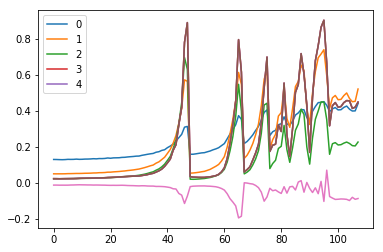

In [0]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class -- as in fastai

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4836)

In [0]:
#export
def children(m): return list(m.children())

class Hook():
    """manual implementation of fastai hooks, only for forward"""
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self)) # passes itself to f
    def remove(self): self.hook.remove() # need to remove hook
    def __del__(self): self.remove() # when python cleans object, obj needs to get remove itsel first

def append_stats(hook, mod, inp, outp):
    # this is going to be the f passed to Hook.__init__ 
    # and partial makes sure its a 3 arg func, while giving it access to hook itslef 
    if not hasattr(hook,'stats'): hook.stats = ([],[]) #first time, we create stats lists in hook 
    means,stds = hook.stats # get each list
    means.append(outp.data.mean()) # # add to them
    stds .append(outp.data.std())

NB: In **fastai we use a `bool` param to choose whether to make it a forward or backward hook**. In the above version we're only supporting forward hooks.

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
hooks = [Hook(l, append_stats) for l in children(model[:4])] # 1 layer 1 hook, only conv layers
# each hook will have inside it the stats for that layers over all batches

In [0]:
run.fit(1, learn)

train: [2.117998125, tensor(0.2486, device='cuda:0')]
valid: [1.21665830078125, tensor(0.5979, device='cuda:0')]


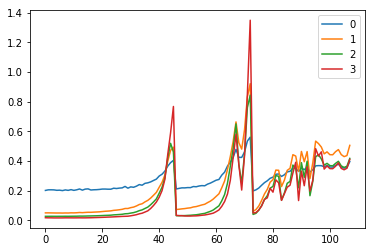

In [0]:
for h in hooks:
    plt.plot(h.stats[0]) # 0 for mean, 1 for stdev
    h.remove() # need to remmove after it was populated 
plt.legend(range(4));

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4972)

In [0]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask, need 1 bool for each item 
            return [o for m,o in zip(idx,self.items) if m] # take only Trues
        return [self.items[i] for i in idx] # only ones in idx (int, slice)
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]' #:-1 takes off ]
        return res

In [0]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [0]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [0]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [0]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self # when getting in context manager
    def __exit__ (self, *args): self.remove() # when get out of context manager 
    def __del__(self): self.remove() # when python clean, trigger all hooks removal

    def __delitem__(self, i):
        self[i].remove() #remove any intem then let it get deleted delete it 
        super().__delitem__(i) #do what u dothen call super, not reverse 
        
    def remove(self):
        # this is where ListContainer.__iter__ gets used 'for h in self'
        for h in self: h.remove() # remove hooks one y one

In [0]:
model,learn,run = None,None,None
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fd4b4ce1dd8>, <__main__.Hook object at 0x7fd4b98e3c88>, <__main__.Hook object at 0x7fd4b662e630>, <__main__.Hook object at 0x7fd4b9022fd0>, <__main__.Hook object at 0x7fd4b4cbddd8>, <__main__.Hook object at 0x7fd4b4cbd630>, <__main__.Hook object at 0x7fd4b4cbda58>]

In [0]:
hooks.remove()

In [0]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [0]:
x.mean(),x.std() # 0,1

(tensor(0.0144, device='cuda:0'), tensor(1.0157, device='cuda:0'))

In [0]:
p = model[0](x)   # u can call just the fist layer like this, or [0:i] for 1st i layers
p.mean(),p.std(), p.shape # mean not 0, std not quite 1 anymore

(tensor(0.1569, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3425, device='cuda:0', grad_fn=<StdBackward0>),
 torch.Size([512, 8, 14, 14]))

In [0]:
for l in model:
    if isinstance(l, nn.Sequential): # only conv2d ie nn.Sequential(nn.Conv2d + Relu)
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [0]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4160, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.7230, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

In [0]:
model,learn,run = None,None,None # make sure to reset when playing with it
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)
for l in model:
    if isinstance(l, nn.Sequential): 
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

train: [1.43858140625, tensor(0.5113, device='cuda:0')]
valid: [0.3079158447265625, tensor(0.9034, device='cuda:0')]
train: [0.2249128125, tensor(0.9312, device='cuda:0')]
valid: [0.13697222900390624, tensor(0.9580, device='cuda:0')]


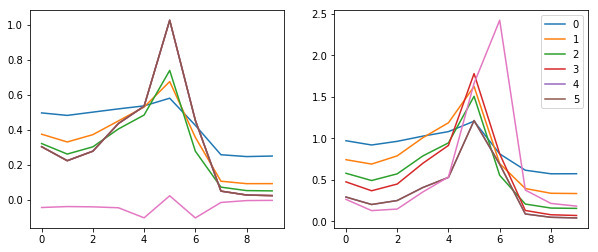

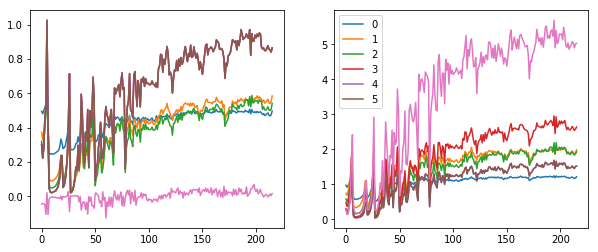

In [0]:
with Hooks(model, append_stats) as hooks: # once out, hooks get removed 
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:# 1st 10
        ms,ss = h.stats
        ax0.plot(ms[:10]) # add meeans of that layer to plot
        ax1.plot(ss[:10]) # std
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:# all iterations
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5233)

In [0]:
#export
def append_stats_1(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [0]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [0]:
with Hooks(model, append_stats_1) as hooks: run.fit(1, learn)

train: [2.1035646875, tensor(0.2744, device='cuda:0')]
valid: [1.412855078125, tensor(0.5696, device='cuda:0')]


In [0]:
#export
# Thanks to @ste for initial version of histgram plotting code; log(1+x) to avoid zeros
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5582)

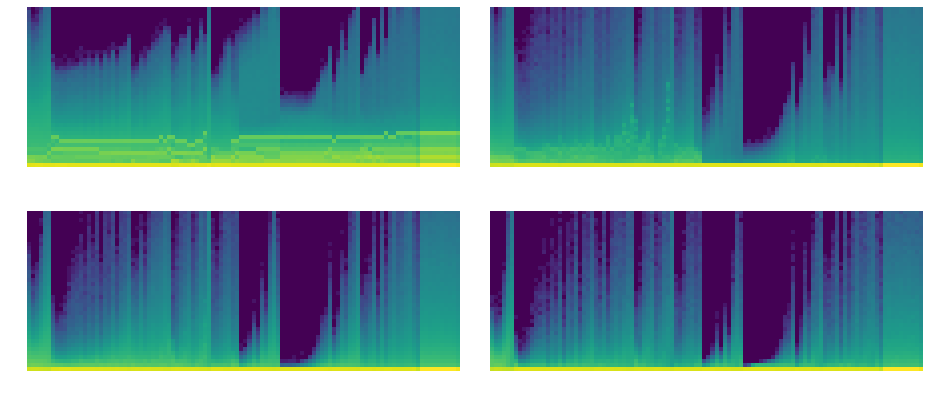

In [0]:
fig,axes = plt.subplots(2,2, figsize=(13,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

From the histograms, we can easily get more informations like the min or max of the activations

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0) # proportion of activations in smaller bins ie close to 0

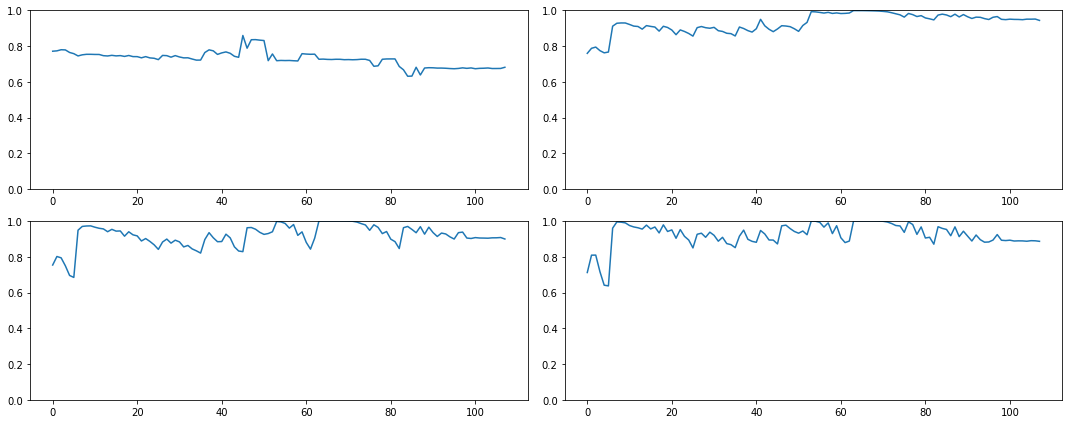

In [0]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()
# about 90% are close to zero

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5390)

In [0]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs): # **kwargs go to GeneralRelu
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs) #i==0
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):# **kwargs go to GeneralRelu
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub) # minus 0.5 e.g.
        if self.maxv is not None: x.clamp_max_(self.maxv) # cap 
        return x

def init_cnn(m, uniform=False,a=0.1): # make a variable
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=a) # vary a i.o fixed 0.1
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):# **kwargs go to GeneralRelu
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [0]:
#export
def append_stats_2(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [0]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.) # -0.4 (coz cap?) and cap at 6
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.51191625, tensor(0.8396, device='cuda:0')]
valid: [0.14257435302734375, tensor(0.9578, device='cuda:0')]


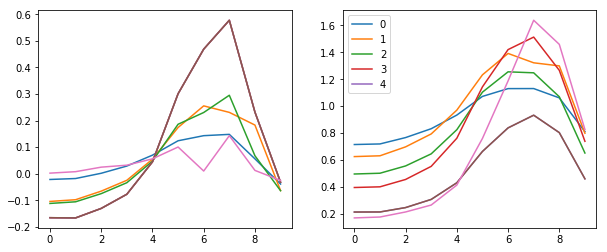

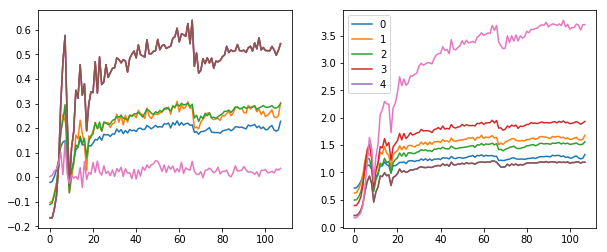

In [463]:
with Hooks(model, append_stats_2) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

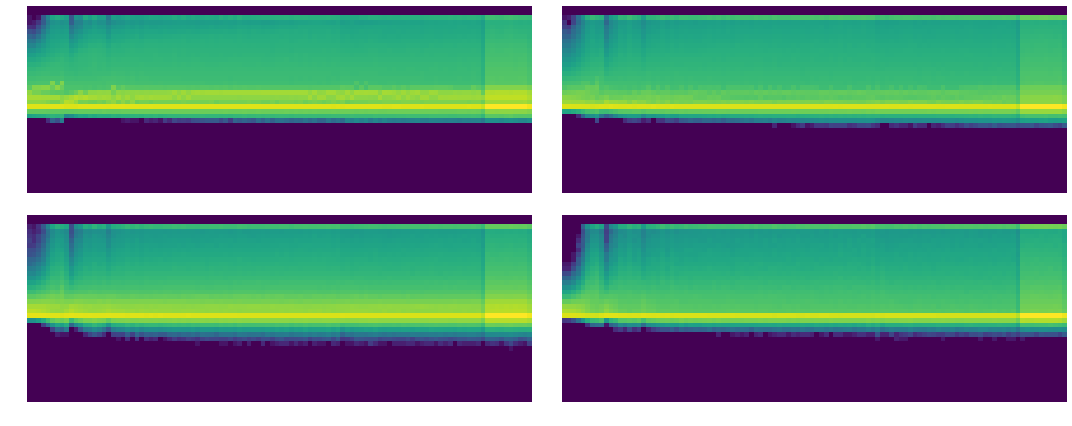

In [464]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()
#less 'deaths', what about yellows, are there many (zeroed acts)?

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0) # as leaky, now middle bins for close to zero acts

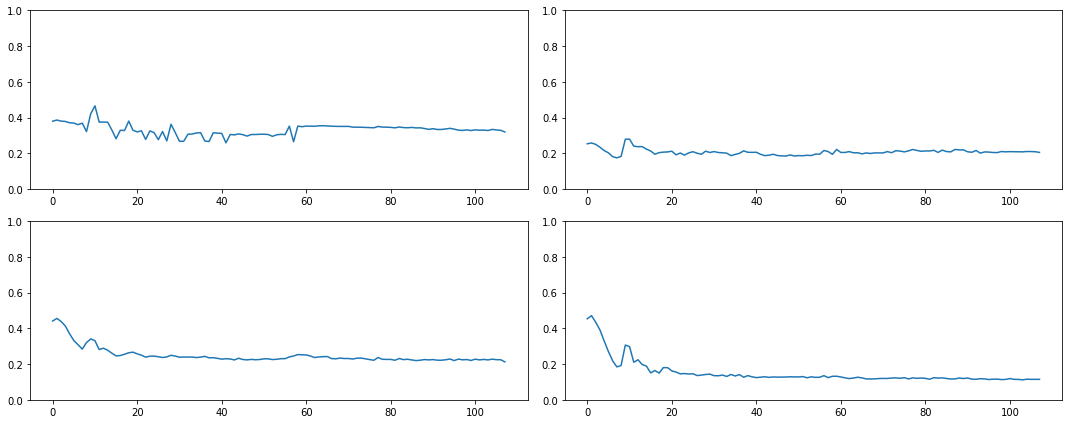

In [443]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()
# less than 20% zeroed

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5705)

In [0]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, a=0.1, **kwargs): # add a var for kaimin
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform, a=a)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
#sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])  #scheduler for lr, 0.2, to 1 then 1 to 0.1

In [0]:
# nfs=nfs; lr,unif,a = 1.,False,0.1;beg_lr=0.2; max_lr=1.0; end_lr = 0.1; runup = 0.5; sched_f = sched_cos; 
nfs=[8,16,32,32]; lr=1.0; unif=False; a = 0.4; 
beg_lr=0.2; max_lr=1.4; end_lr = 0.1; runup = 0.7; sched_f = sched_cos; 
sched = combine_scheds([runup, 1-runup], [sched_f(beg_lr, max_lr), sched_f(max_lr, end_lr)])

In [0]:
learn,run = get_learn_run(nfs, data, lr, conv_layer,uniform=unif, a=a,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [753]:
run.fit(8, learn)

train: [0.96739546875, tensor(0.6957, device='cuda:0')]
valid: [0.2877072021484375, tensor(0.9134, device='cuda:0')]
train: [0.30109541015625, tensor(0.9100, device='cuda:0')]
valid: [0.16501163330078125, tensor(0.9510, device='cuda:0')]
train: [0.27313416015625, tensor(0.9190, device='cuda:0')]
valid: [0.131910986328125, tensor(0.9615, device='cuda:0')]
train: [0.146507314453125, tensor(0.9564, device='cuda:0')]
valid: [0.109859228515625, tensor(0.9667, device='cuda:0')]
train: [0.465955625, tensor(0.8611, device='cuda:0')]
valid: [0.13483966064453126, tensor(0.9601, device='cuda:0')]
train: [0.11013666015625, tensor(0.9655, device='cuda:0')]
valid: [0.08354947509765626, tensor(0.9745, device='cuda:0')]
train: [0.0690123388671875, tensor(0.9790, device='cuda:0')]
valid: [0.06832042236328124, tensor(0.9800, device='cuda:0')]
train: [0.0465538623046875, tensor(0.9858, device='cuda:0')]
valid: [0.06294487915039063, tensor(0.9826, device='cuda:0')]


Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [0]:
learn,run = get_learn_run(nfs, data, lr, conv_layer, uniform=(not unif), a=a,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [761]:
run.fit(8, learn)

train: [1.036586953125, tensor(0.6755, device='cuda:0')]
valid: [0.3444853271484375, tensor(0.8950, device='cuda:0')]
train: [0.3832883203125, tensor(0.8843, device='cuda:0')]
valid: [0.19167554931640626, tensor(0.9455, device='cuda:0')]
train: [0.20844576171875, tensor(0.9361, device='cuda:0')]
valid: [0.135592626953125, tensor(0.9570, device='cuda:0')]
train: [nan, tensor(0.4583, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [0]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [0]:
nb_auto_export()

<IPython.core.display.Javascript object>

In [762]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb

Converted 06_cuda_cnn_hooks_init.ipynb to exports/lg_06.py


In [0]:
#!pip install fire